In [1]:
import os
import torchio as tio

from mbas.data.nifti import make_subject
from mbas.visualize.subject import plot_subject_with_label

%load_ext autoreload
%autoreload 2

import numpy as np
import pickle

import scipy

from scipy.spatial.distance import cdist
import torch

2024-06-04 22:26:44.293817: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-04 22:26:44.318558: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-04 22:26:44.674283: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
subject = make_subject(
    "/home/bryan/data/MBAS/Training/MBAS_005",
    "train",
)

In [3]:
subject.label

LabelMap(shape: (1, 576, 576, 44); spacing: (0.62, 0.62, 2.50); orientation: LPS+; path: "/home/bryan/data/MBAS/Training/MBAS_005/MBAS_005_label.nii.gz")

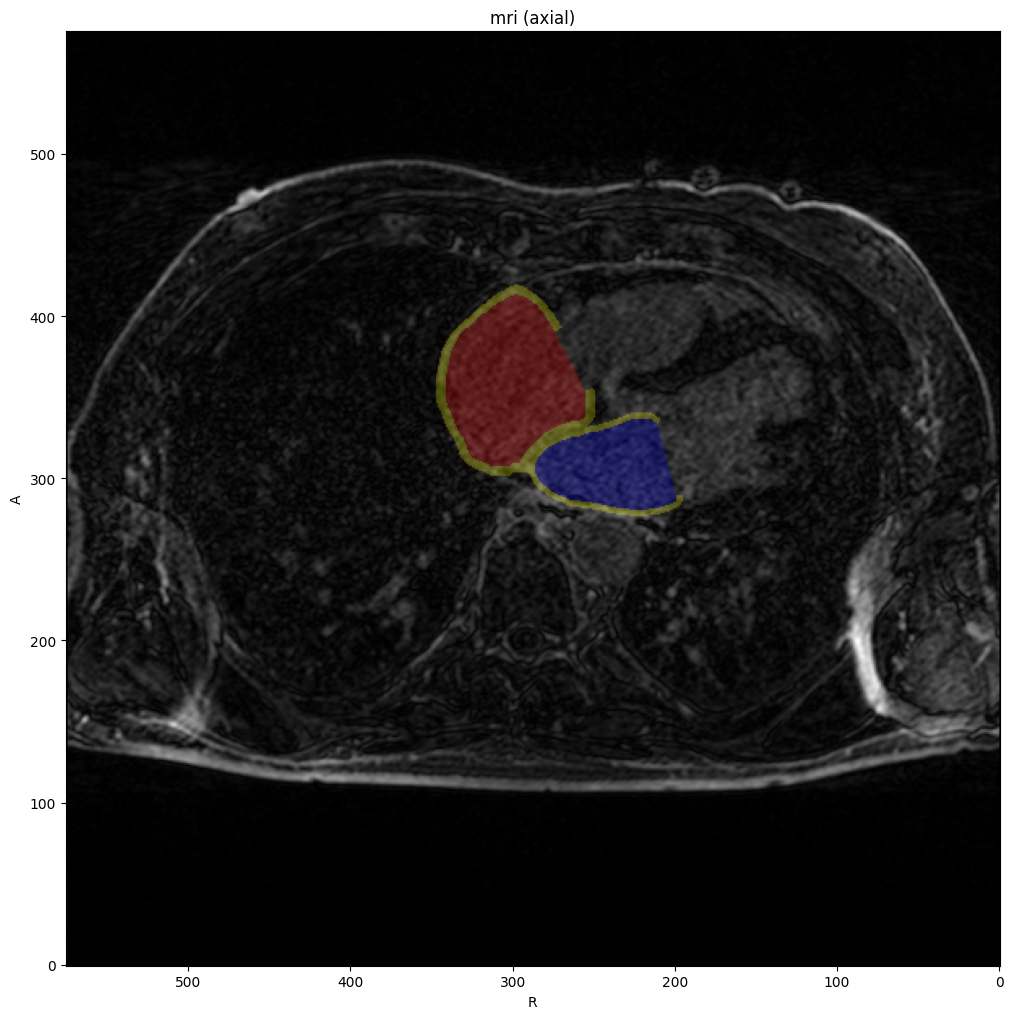

In [4]:
plot_subject_with_label(
    subject,
    show=True,
    add_metadata=False,
    add_segmentation_legend=False,
    single_axis="axial",
    label_key="label",
    cmap="mbas",
    indices = (300, 300, 15),
    figsize=(10,10)
);

In [5]:
label_volume = subject.label.data.numpy()

In [6]:
def get_indices(label_index):
    return np.transpose(np.where(label_volume == label_index))

wall_indices = get_indices(1)
right_indices = get_indices(2)
left_indices = get_indices(3)

def get_min_dist(target_indices, batch_size = 1000):
    min_dists = []
    min_indices = []
    for slice_start in range(0, len(wall_indices), batch_size):
        wall_slice = wall_indices[slice_start:slice_start+batch_size]
        wall_to_target = cdist(wall_slice, target_indices)
        min_dists.extend(np.min(wall_to_target, axis=1).tolist())
        min_indices.extend(np.argmin(wall_to_target, axis=1).tolist())
    return min_dists, min_indices

wall_to_right_dists, wall_to_right_indices = get_min_dist(right_indices)

# wall_to_right = cdist(wall_indices, right_indices)
# wall_to_left = cdist(wall_indices, left_indices)

In [7]:
wall_to_left_dists, wall_to_left_indices = get_min_dist(left_indices)

In [8]:
label_volume_hier = label_volume.copy()

In [9]:
for i in range(len(wall_indices)):
    wall_to_right = wall_to_right_dists[i]
    wall_to_left = wall_to_left_dists[i]
    if wall_to_right < wall_to_left:
        label_volume_hier[tuple(wall_indices[i])] = 4

In [10]:
label_volume_hier.max()

4

In [11]:
label_heir = tio.LabelMap(
    tensor = torch.from_numpy(label_volume_hier),
    affine = subject.label.affine,
    name = "label_hierarchical"
)
subject.add_image(label_heir, "label_hierarchical")

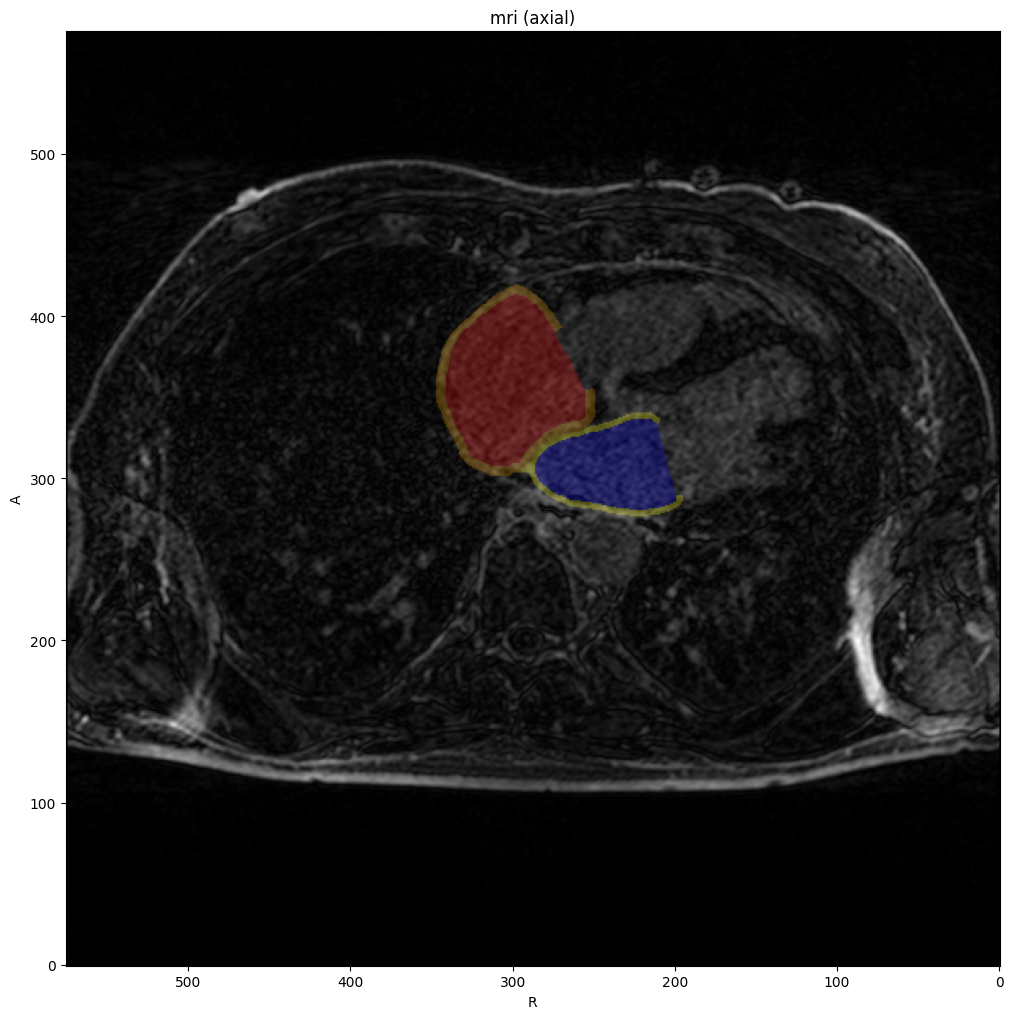

In [19]:
plot_subject_with_label(
    subject,
    show=True,
    add_metadata=False,
    add_segmentation_legend=False,
    single_axis="axial",
    label_key="label_hierarchical",
    cmap="mbas_hierarchical",
    indices = (300, 300, 15),
    figsize=(10,10)
);

In [22]:
path = str(subject.label.path).replace("label", "label_hierarchical")
print(path)
# label_heir.save(path)

/home/bryan/data/MBAS/Training/MBAS_005/MBAS_005_label_hierarchical.nii.gz


In [23]:
label_reload = tio.LabelMap(path=path)

In [24]:
label_reload

LabelMap(shape: (1, 576, 576, 44); spacing: (0.62, 0.62, 2.50); orientation: LPS+; path: "/home/bryan/data/MBAS/Training/MBAS_005/MBAS_005_label_hierarchical.nii.gz")